In [21]:
import rasterio
import numpy as np
import rasterstats as rs
import pandas as pd
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset

In [22]:
# Loading raster data
# Load DEM (Digital Elevation Model), orthophoto (multi-band), and DTM (Digital Terrain Model) using rasterio
dem=rasterio.open('data/dem.tif')
ortho=rasterio.open('data/ortho.tif')
dtm=rasterio.open('data/dtm.tif')

In [23]:
# Reading arrays from raster data
# Reading the first band for DEM and DTM, and the first six bands for orthophoto
dem_arr=dem.read(1)
ortho_arr=ortho.read([1,2,3,4,5,6])# R,G,B,NIR,RedEdge,Thermal
dtm_arr=dtm.read(1)

In [24]:
# now loading vector data
# loading shapefiles data containing plot data
plots_1=gpd.read_file('data/plots_1.shp')
plots_2=gpd.read_file('data/plots_2.shp')

In [25]:
# Masking invalid data to nan
# Seting invalid elevation and thermal values to nan
elevation=np.where(dem_arr<= 0,np.nan,dem_arr)
masked_thermal=np.where(ortho_arr[5]<=0,np.nan,ortho_arr[5]/100-273.15)# Convert to Celsius

# Generate NDVI (Normalized Difference Vegetation Index) with error handling
# NDVI=(NIR - Red)/(NIR + Red)
with np.errstate(divide='ignore',invalid='ignore'):
    ndvi=(ortho_arr[3]-ortho_arr[0])/(ortho_arr[3]+ortho_arr[0])
    ndvi=np.where(np.isnan(ndvi), 0, ndvi)

# Compute zonal statistics for each plot
# This function calculates the mean of the raster data within each plot geometry
def compute_zonal_stats(plots,data,affine):
    plot_zs=rs.zonal_stats(plots,data,affine=affine,stats="mean",nodata=np.nan,geojson_out=True)
    return gpd.GeoDataFrame.from_features(plot_zs)

In [26]:
# Calculate mean NDVI, thermal, elevation, and DTM values for each plot
plots_1['NDVI_mean']=compute_zonal_stats(plots_1, ndvi,dem.transform)['mean']
plots_1['thermal_mean']=compute_zonal_stats(plots_1,masked_thermal,dem.transform)['mean']
plots_1['elevation_mean']=compute_zonal_stats(plots_1,elevation,dem.transform)['mean']
plots_1['dtm_mean']=compute_zonal_stats(plots_1, dtm_arr,dem.transform)['mean']

# Data preparation
# Drop NaN values and prepare feature matrix for model training
plots_1 = plots_1.dropna()
features = plots_1[['NDVI_mean','thermal_mean','elevation_mean','dtm_mean']]

# Create a synthetic target variable focusing on healthy crops
# Define healthy crops based on NDVI values between 0.4 and 0.8
healthy_mask = (plots_1['NDVI_mean']>= 0.4) & (plots_1['NDVI_mean']<= 0.8)
plots_1['synthetic_target'] = np.where(healthy_mask, 1, 0)  # Healthy crops = 1, Others = 0

# Checking data balance
# Printing class distribution to check for imbalance
class_counts =plots_1['synthetic_target'].value_counts()
print(f"Class distribution:\n{class_counts}")

# Handle data imbalance by undersampling the majority class
from sklearn.utils import resample

# Separate majority and minority classes
# This variable indicates whether a crop is healthy (1) or not (0).
minority_class=plots_1[plots_1['synthetic_target']==1]
majority_class=plots_1[plots_1['synthetic_target']==0]

# Resample majority class to match the minority class size
majority_class_downsampled=resample(majority_class,
                                      replace=False,
                                      n_samples=len(minority_class),
                                      random_state=42)
balanced_data = pd.concat([minority_class,majority_class_downsampled])

# Reassign features and target from the balanced data
features=balanced_data[['NDVI_mean', 'thermal_mean','elevation_mean','dtm_mean']]
target=balanced_data['synthetic_target']

# Split data into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=42)

# Standardize data
# Standardize features to have zero mean and unit variance
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

Class distribution:
synthetic_target
0    78
1    54
Name: count, dtype: int64


In [27]:
# Data preparation remains unchanged
# ... (loading raster and vector data, computing NDVI, handling NaNs, creating balanced data, etc.)

# Convert data to PyTorch tensors
X_train_tensor =torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor= torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # Unsqueeze for compatibility
y_test_tensor= torch.tensor(y_test.values,dtype=torch.float32).unsqueeze(1)

# Create DataLoader for training data
train_dataset=TensorDataset(X_train_tensor,y_train_tensor)
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)

# Defining the neural network model using PyTorch
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet,self).__init__()
        self.fc1=nn.Linear(X_train.shape[1],128)
        self.dropout1=nn.Dropout(0.3)
        self.fc2=nn.Linear(128, 64)
        self.dropout2=nn.Dropout(0.3)
        self.fc3= nn.Linear(64, 1)
        self.sigmoid=nn.Sigmoid()

    def forward(self, x):
        x=torch.relu(self.fc1(x))
        x=self.dropout1(x)
        x=torch.relu(self.fc2(x))
        x=self.dropout2(x)
        x=self.sigmoid(self.fc3(x))
        return x

# Instantiate the model, define the loss function and optimizer
model=NeuralNet()
criterion=nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer=optim.Adam(model.parameters(),lr=0.001)

# Train the model
epochs=100
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch,y_batch in train_loader:
        optimizer.zero_grad()
        outputs=model(X_batch)
        loss=criterion(outputs,y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    if (epoch+1)%10==0:
        print(f"Epoch{epoch+ 1}/{epochs},Loss:{epoch_loss/len(train_loader):.4f}")

model.eval()

Epoch10/100,Loss:0.3340
Epoch20/100,Loss:0.1654
Epoch30/100,Loss:0.1214
Epoch40/100,Loss:0.0756
Epoch50/100,Loss:0.0785
Epoch60/100,Loss:0.0613
Epoch70/100,Loss:0.0878
Epoch80/100,Loss:0.0509
Epoch90/100,Loss:0.0375
Epoch100/100,Loss:0.0595


NeuralNet(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [29]:
# Converting predictions to Numpy
predictions_binary_np=predictions_binary.numpy()

# Ensure y_test is a Numpy array
if not isinstance(y_test,np.ndarray):
    y_test=y_test.to_numpy()

# Evaluation metrics
accuracy_score_val=accuracy_score(y_test, predictions_binary_np)
precision_score_val=precision_score(y_test, predictions_binary_np)
recall_score_val=recall_score(y_test, predictions_binary_np)
f1_score_val=f1_score(y_test,predictions_binary_np)
roc_auc_score_val=roc_auc_score(y_test, predictions.detach().numpy())

print(f"Accuracy Score: {accuracy_score_val}")
print(f"Precision Score: {precision_score_val}")
print(f"Recall Score: {recall_score_val}")
print(f"F1 Score: {f1_score_val}")
print(f"ROC AUC Score: {roc_auc_score_val}")

Accuracy Score: 0.9545454545454546
Precision Score: 1.0
Recall Score: 0.9
F1 Score: 0.9473684210526315
ROC AUC Score: 1.0


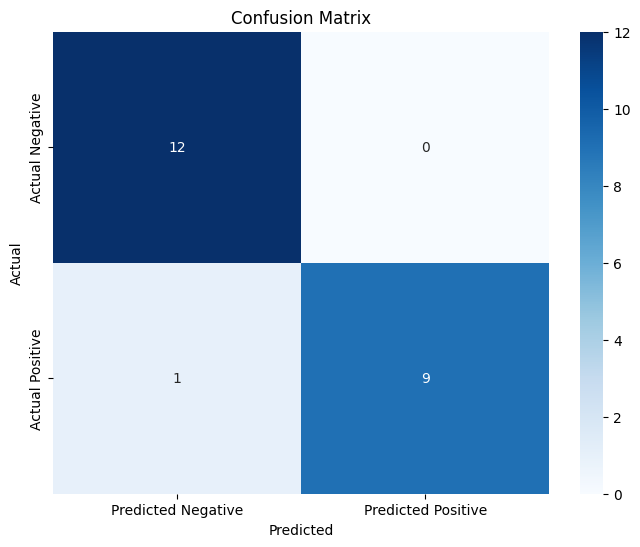

In [30]:
# Plot the confusion matrix
conf_matrix=confusion_matrix(y_test,predictions_binary)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d',cmap='Blues',
            xticklabels=['Predicted Negative','Predicted Positive'],
            yticklabels=['Actual Negative','Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()